<a href="https://colab.research.google.com/github/tatsath/PortfolioOptimization/blob/main/Portfolio_Optimisation_1asset_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [50]:
import numpy as np

import seaborn as sns
import numpy.matlib


import matplotlib.pyplot as plt
from matplotlib import cm

from scipy import stats
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time

import copy

#Other packages: 
import pandas as pd

import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance'}
missing = required - installedPackages
if missing:
    !pip install yfinance   
import yfinance as yf



In [51]:
torch.manual_seed(121)
torch.cuda.manual_seed(121)

In [52]:
# Dow 30 constituents at 2019/01/01
dow_30_ticker = ['AAPL','MSFT','JPM','V','RTX','PG','GS','NKE','DIS','AXP',
                  'HD','INTC','WMT','IBM','MRK','UNH','KO','CAT','TRV','JNJ',
                  'CVX','MCD','VZ','CSCO','XOM','BA','MMM','PFE','WBA','DD', '^DJI'] 

In [53]:
dow_30 = pd.DataFrame()
for tic in dow_30_ticker:
    data_df = yf.download(tic, start="2009-01-01", end="2020-10-23")
    data_df['tic'] = tic
    dow_30=dow_30.append(data_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [54]:
dow_30.head()

,Open,High,Low,Close,Adj Close,Volume,tic
Date,,,,,,,
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.773207,7.460152e+08,AAPL
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.890248,1.181608e+09,AAPL
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.842576,1.289310e+09,AAPL
2009-01-07,3.278929,3.303571,3.223572,3.250357,2.781153,7.530488e+08,AAPL
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.832797,6.735008e+08,AAPL


Next Steps: 
#Pivot by the ticker and get the return and std 
#Get the meu sigma and std and correlation matrix of the stocks.
https://towardsdatascience.com/simulating-stock-prices-in-python-using-geometric-brownian-motion-8dfd6e8c6b18
#Get the weight as of 1st of November and see the weights of the benchmark intitially
#What we will see is that more number of assets the weightes become more weird and then there is more deviation from the benchmark at T
#Calibrate the model till 2017 and backtest on the next 3 years. 

Other analysis : 

* #Bond and equities benchmark.
* #Why the model increases the weights all of a sudden on 15th day as compared to the benchmark ( to focus on the risk measure loss funcion)

In [55]:
# params = {
#     "S0" : np.array([1]),
#     "mu" : np.array([0.03]),
#     "sigma" : np.array([0.2]),
#     "rho" : np.array([[1]]),
#     "rf" : 0.01,
#     "delta" : np.array([0.7])
#     }

params = {
    "S0" : np.array([1, 2]),
    "mu" : np.array([0.05, 0.06]),
    "sigma" : np.array([0.1, 0.12]),
    "rho" : np.array([[1, 0.25],[0.25,1]]),
    "rf" : 0.01,
    "delta" : np.array([0.25, 0.75])
    }

params_Q = copy.copy(params)
params_Q["mu"] = np.array([params_Q["rf"], params_Q["rf"]])

print(params)

print(params_Q)

{'S0': array([1, 2]), 'mu': array([0.05, 0.06]), 'sigma': array([0.1 , 0.12]), 'rho': array([[1.  , 0.25],
       [0.25, 1.  ]]), 'rf': 0.01, 'delta': array([0.25, 0.75])}
{'S0': array([1, 2]), 'mu': array([0.01, 0.01]), 'sigma': array([0.1 , 0.12]), 'rho': array([[1.  , 0.25],
       [0.25, 1.  ]]), 'rf': 0.01, 'delta': array([0.25, 0.75])}


In [56]:
#%% Simulation Engine for price paths
def SimPath(Ndt, params, T, Nsims):
    
    dt = T/Ndt
    
    N_assets= params["mu"].shape[0]
    
    assert N_assets == params["sigma"].shape[0], "#assets in mu != #assets in sigma"
    assert N_assets == params["rho"].shape[0], "#assets in mu != #assets in rho"
    assert params["rho"].ndim == 2, "rho must be matrix"
    assert N_assets == params["rho"].shape[1], "rho not square matrix"
    
    S = np.zeros((Ndt+1, Nsims, N_assets ))
    S[0,:,:] = params["S0"]

    
    for i in range(Ndt):
        
        dW = np.sqrt(dt) * np.random.multivariate_normal(np.zeros(N_assets), params["rho"], Nsims)
        S[i+1,:,:] = S[i,:,:] * np.exp((params["mu"]-0.5*params["sigma"]**2)*dt + params["sigma"]*dW)
        
    t = np.linspace(0,T,Ndt+1)
    return t, S
        

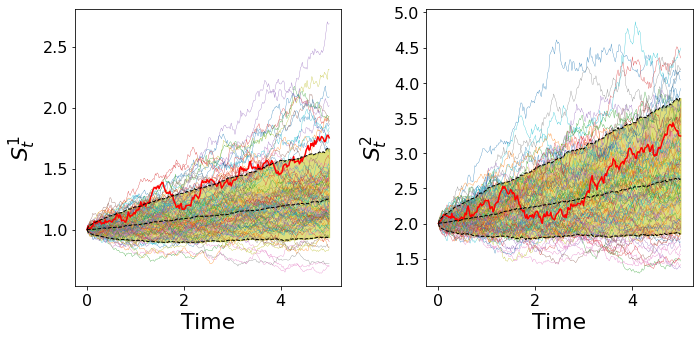

In [57]:
# Sim some paths and show sims with quantiles and a sample path
t, S = SimPath(Ndt=252, params = params, T=5, Nsims = 1000)

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 16})
plt.rc('axes', labelsize=22)
for i in range(S.shape[2]):
    
    plt.subplot(1,S.shape[2],i+1)
    
    plt.fill_between(t, np.quantile(S[:,:,i],0.1,axis=1).T, np.quantile(S[:,:,i],0.9,axis=1).T, color='y', alpha=0.5)
    plt.plot(t, S[:,:100,i],linewidth=0.3)
    plt.plot(t, S[:,0,i],color='r',linewidth=1.5)
    plt.plot(t, np.quantile(S[:,:,i],[0.1, 0.5, 0.9],axis=1).T,color='k',linewidth=1, linestyle='--')
    
    plt.xlabel("Time")
    plt.ylabel("$S_t^" +str(i+1)+"$")
    
plt.tight_layout()
plt.show()

In [58]:
# the ANN for policy iteration
class MyNet(nn.Module):
    
    def __init__(self, n, n_assets ):
        super(MyNet, self).__init__()

        # 2 input layer (t, X_t^delta), 1 output channel, 3 hidden layers with n units each
        self.f_in_to_h1 = nn.Linear( 2 , n)
        self.f_h1_to_h2 = nn.Linear(n, n)
        self.f_h2_to_out = nn.Linear(n, n_assets)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        
        # input into 1st hidden layer
        h1 = self.myReLU(self.f_in_to_h1(x) )
        
        # 1st hidden to 2nd hidden layer
        h2 = self.myReLU(self.f_h1_to_h2(h1))
            
        # 2nd hidden layer to output layer
        y = self.f_h2_to_out(h2)      
        #y = y.clamp(-1,1)
        #y = F.logsigmoid(h2)
        
        return y

In [59]:
# from a minibatch compute the risk measure
def GetRiskMeasure(X, Type):
    #TVaR    
    if (Type == "TVaR"):
        
        alpha = 0.15
        Qtl= torch.quantile(X, alpha)
        RiskMeasure = -torch.mean(X[X<=Qtl])
    
    # alpha-beta
    elif (Type == "alpha-beta" ):
        
        alpha = 0.1
        LQtl = torch.quantile(X,alpha)
        
        beta = 0.9
        UQtl = torch.quantile(X,beta)
        
        # weight factor (p in the paper)
        p = 0.25
        eta = p * alpha + (1-p) * (1-beta)
        RiskMeasure = -(p* torch.mean(X[X<=LQtl]) \
                        + (1-p) * torch.mean(X[X>=UQtl] ) )/eta
        
        
    #Variance
    elif (Type == "Variance"):  
        RiskMeasure = torch.var(X)   
        
    return RiskMeasure

In [60]:
# from a minibatch compute the Wasserstein Distance
def getWassDistance(X, Y):
    
    # generate co-monotonic versions of the sample
    X_sorted, _ = torch.sort(X)
    Y_sorted, _ = torch.sort(Y)
    
    wass_dist = torch.sqrt(torch.mean(( X_sorted - Y_sorted )**2))
    
    return wass_dist 

In [61]:
# given an ANN run a simulation and compute the riskmeasure
def SimRM(net, Ndt, T, Nsims, params, device):
      
    t, S = SimPath(Ndt, params, T=T, Nsims=Nsims)  
    
    # initial investment amount
    X0 = 1
    
    num_asset = S.shape[2]
    dt = t[1]-t[0]
    
    # don't think we need sensitivities w.r.t. this as they are fixed per simulation
    S_t = torch.tensor(S, dtype=torch.float, requires_grad=False, device=device)
    
    S_Ret = (S_t[1:,:,:]-S_t[:-1,:,:])/S_t[:-1,:,:]
    
    #Benchmark Delta and return
    Delta_t = torch.zeros((Ndt, Nsims, num_asset), \
                                 dtype=torch.float, requires_grad=False, device=device)
    # note only 90% invested in risky assets here... 10% in risk-free
    delta = torch.tensor(params["delta"],requires_grad=False, device=device)
    delta_r = 1 - torch.sum(delta)
    Delta_t += delta 

    # accumulate returns as we go along
    Benchmark_Ret = delta_r * params["rf"] * dt+ torch.sum(Delta_t * S_Ret , axis=2)
    
    BenchmarkVal_path = torch.zeros((Ndt+1,Nsims), dtype=torch.float, requires_grad=False, device=device)
    BenchmarkVal_path[0,:]  = X0
    BenchmarkVal_path[1:,:] = X0*torch.cumprod( (1.0+Benchmark_Ret), axis=0)
    BenchmarkVal_T = BenchmarkVal_path[-1,:].reshape(-1,1)
    
    #
    # Getting the portfolio weights using benchmark value and time as features
    #
    x=np.zeros((Ndt+1, Nsims, 2))   
    
    x[:,:,0] = np.matlib.repmat(t.reshape(-1,1)/t[-1], 1, Nsims)
    xt = torch.tensor(x, dtype=torch.float, device=device)
    
    xt[:,:,1] = BenchmarkVal_path/X0
    
    wt = net(xt)    
    
    # the candidate portolio
    Portfolio_Ret = (1-torch.sum(wt[:-1,:,:], axis=2)) * params["rf"] * dt+ torch.sum(wt[:-1,:,:] * S_Ret , axis=2)
    
    PortfolioVal_path = torch.zeros((Ndt+1,Nsims), dtype=torch.float, requires_grad=False, device=device)    
    PortfolioVal_path[0,:] = X0
    PortfolioVal_path[1:,:] = X0*torch.cumprod( (1.0+Portfolio_Ret), axis=0)
    PortfolioVal_T = PortfolioVal_path[-1,:].reshape(-1,1)
        
    
    # Compute the risk measure and wasstertein Distance for the computation
    wass_dist = getWassDistance(PortfolioVal_T, BenchmarkVal_T)
    RiskMeasure = GetRiskMeasure(PortfolioVal_T, "alpha-beta") 
    
    return wt, RiskMeasure, wass_dist, PortfolioVal_T, BenchmarkVal_T, t, BenchmarkVal_path.cpu().detach().numpy(), PortfolioVal_path.cpu().detach().numpy()

In [62]:
# plot histogram of portfolio, sample path, and show dependence of X^\pi on X^\delta
def PlotHists(X, Y, t, X_path, Y_path):
    
    Xcp = X.clone().cpu().detach().numpy()
    Ycp = Y.clone().cpu().detach().numpy()
    
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)
    bins = np.linspace(0,4,50)
    
    sns.distplot(Xcp, hist=True, kde=True,  bins=bins, label='Benchmark')
    sns.distplot(Ycp,  hist=True, kde=True, bins=bins, label='Portfolio')  
    
    plt.axvline(np.quantile(Xcp, 0.05),color='k',linewidth=0.5)
    plt.axvline(np.quantile(Ycp, 0.05),color='r',linewidth=0.5)
    
    plt.legend()
    plt.xlim(0,4)
    

    plt.subplot(1,3,2)
    plt.fill_between(t, np.quantile(X_path,0.1,axis=1).T, np.quantile(X_path,0.9,axis=1).T, color='y', alpha=0.5)
    plt.fill_between(t, np.quantile(Y_path,0.1,axis=1).T, np.quantile(Y_path,0.9,axis=1).T, color='g', alpha=0.5)
    plt.plot(t,X_path[:,0], label='Benchmark', color='r')
    plt.plot(t,np.quantile(X_path,[0.1,0.5,0.9],axis=1).T, '--y')
    plt.plot(t,Y_path[:,0], label='Portfolio', color='k')
    plt.plot(t,np.quantile(Y_path,[0.1,0.5,0.9],axis=1).T, '--g')
    
    plt.legend()
    
    
    plt.subplot(1,3,3)
    xs = [min(Xcp), max(Xcp)]
    plt.plot(xs,xs,'--k' )
    plt.scatter(Xcp,Ycp, marker='o',color='r', s=5)
    plt.xlim(0,5)
    plt.ylim(0,5)
    
    plt.rcParams.update({'font.size': 16})
    plt.rc('axes', labelsize=22)
    
    plt.tight_layout()
    
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


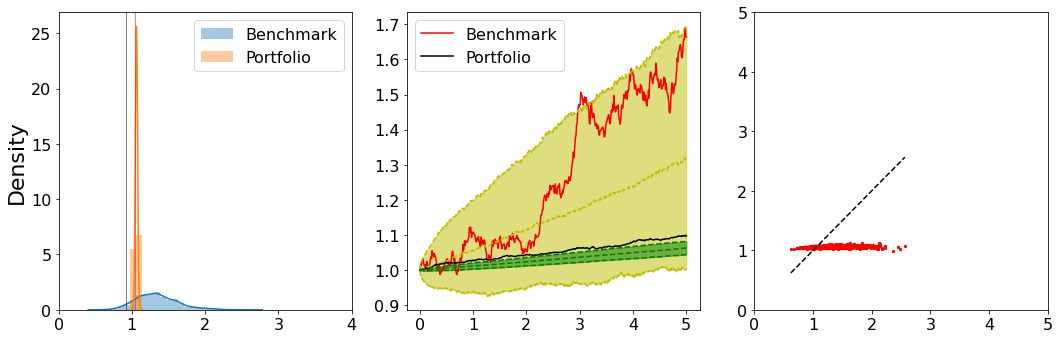

In [63]:
# create an ANN and use GPU if available

if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 

net = MyNet(50, len(params["S0"])).to(device)

wt, RiskMeasure, wass_dist, PortfolioVal_T, BenchmarkVal_T, \
    t, BenchmarkVal_path, PortfolioVal_path = SimRM(net, Ndt=500, T=5, Nsims=1000, params=params, device=device)
    
PlotHists(BenchmarkVal_T, PortfolioVal_T, t, BenchmarkVal_path, PortfolioVal_path)


In [64]:
PortfolioVal_path.shape

(501, 1000)

In [65]:
torch.cuda.is_available()

True

...........10 duaration =  12.525  secs
Wass Dist: 0.261 Risk Measure: -12.739 Loss: 13.372


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


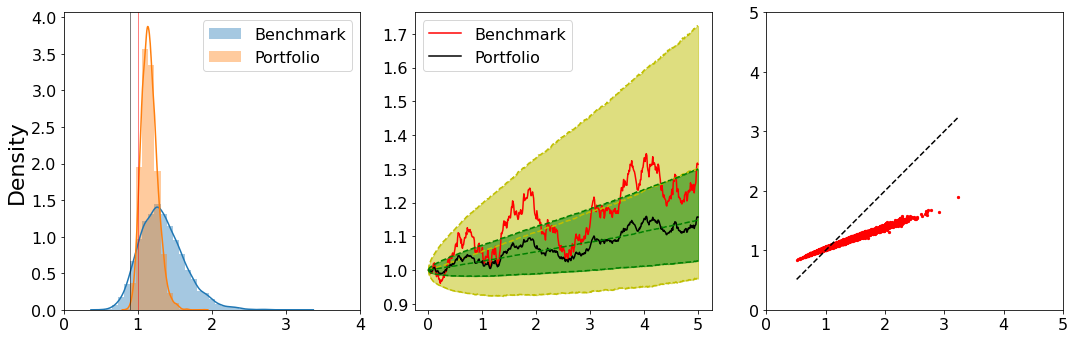

0.9997042 0.99989843

..........20 duaration =  13.729  secs
Wass Dist: 0.124 Risk Measure: -15.062 Loss: -15.062


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


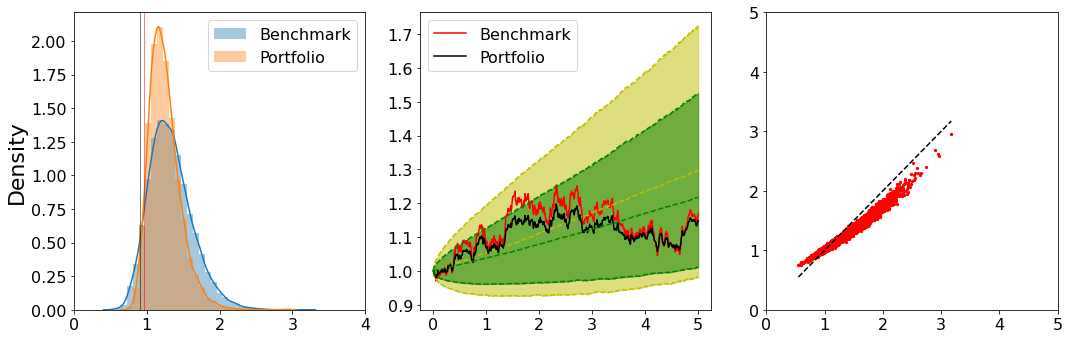

1.0006977 1.000336

..........30 duaration =  13.819  secs
Wass Dist: 0.065 Risk Measure: -17.063 Loss: -17.063


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


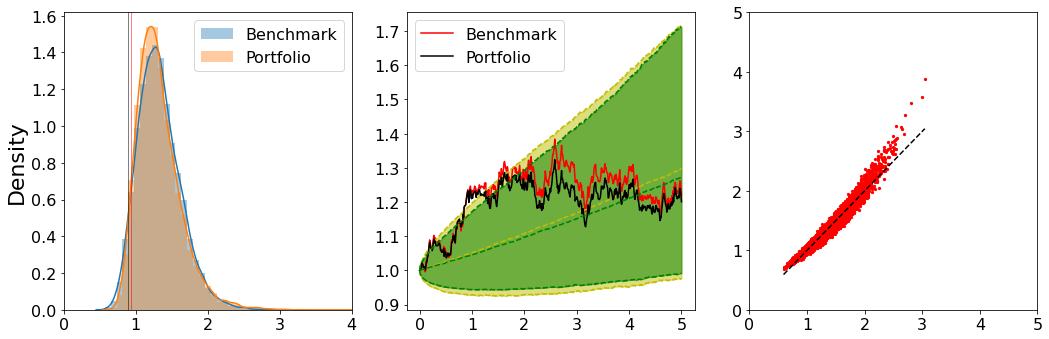

1.0011141 1.0016104

..........40 duaration =  13.885  secs
Wass Dist: 0.184 Risk Measure: -19.616 Loss: -19.616


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


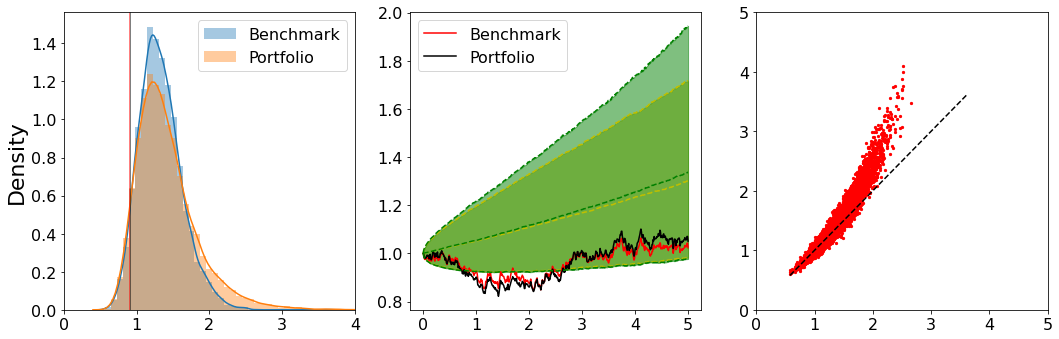

0.99967253 0.9992518

..........50 duaration =  13.812  secs
Wass Dist: 0.144 Risk Measure: -19.112 Loss: -19.112


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


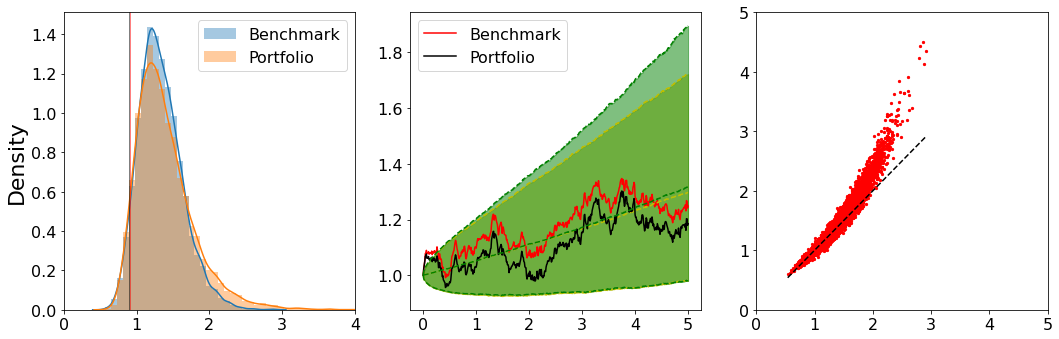

1.0000188 0.9995972

..........60 duaration =  13.785  secs
Wass Dist: 0.181 Risk Measure: -19.843 Loss: -19.843


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


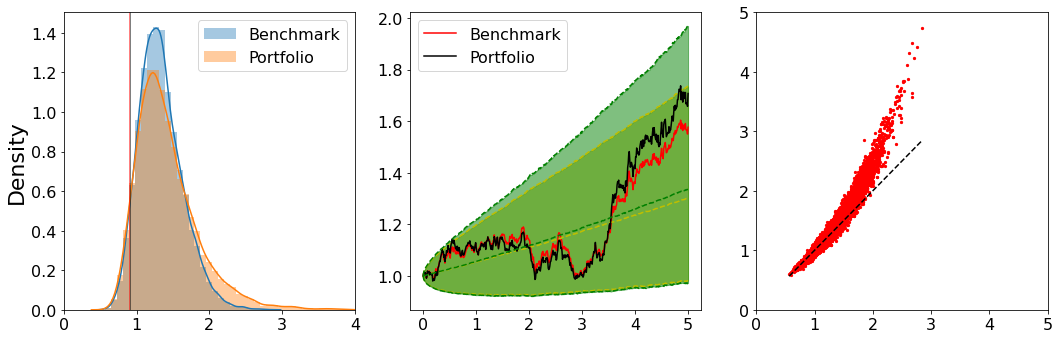

1.0041437 1.0046632

..........70 duaration =  13.771  secs
Wass Dist: 0.166 Risk Measure: -19.702 Loss: -19.702


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


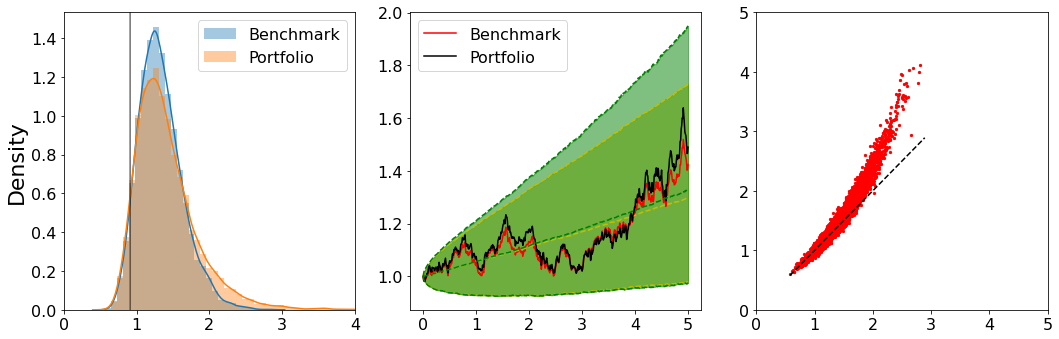

0.99865097 0.99819696

..........80 duaration =  13.962  secs
Wass Dist: 0.203 Risk Measure: -20.245 Loss: 0.077


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


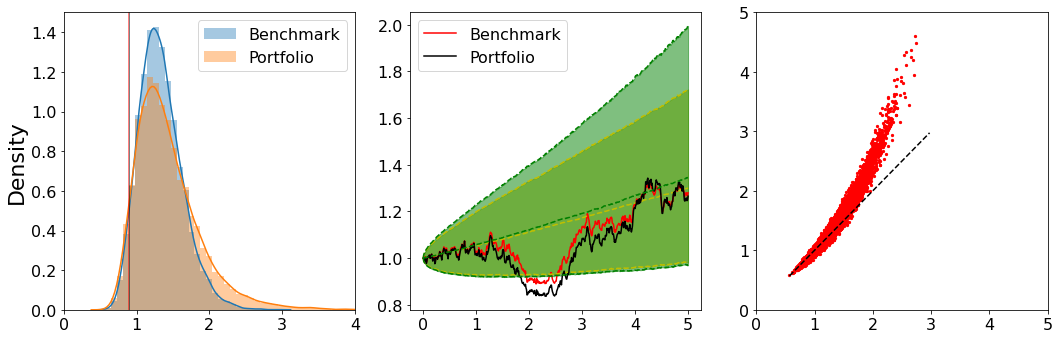

1.0031991 1.003259

..........90 duaration =  13.807  secs
Wass Dist: 0.164 Risk Measure: -19.574 Loss: -19.574


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


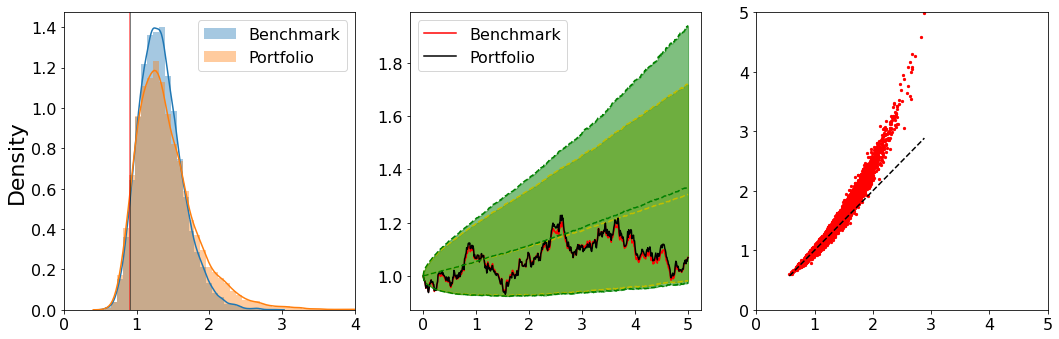

0.9988475 0.99878967

.........Finished Training


In [66]:
# train the model

optimizer = optim.Adam(net.parameters())


Nepochs = 100
loss_hist = []
risk_history = []
wass_dist_history=[]

start_time= time.time()

for epoch in range(Nepochs):  # loop over the dataset multiple times

    
    
    # zero the parameter gradients
    optimizer.zero_grad()


    #hedge_payoff, true_payoff, S = SimHedge(net, Ndt, S0, mu, sigma, T, Nsims, True)
    wt, RiskMeasure, wass_dist, PortfolioVal_T, IndexVal_T, t, IndexVal_path, PortfolioVal_path \
        = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params, device=device)
    
    loss = 100*(wass_dist)*(wass_dist>0.2) + RiskMeasure
    
    
    loss.backward()   
    
    # optimize
    optimizer.step()
    
    # store running loss
    loss_hist.append(  loss.item() )
    risk_history.append( RiskMeasure.cpu().detach().numpy() )
    wass_dist_history.append( wass_dist.cpu().detach().numpy() )
    
    print(".",end="")
    
    # plot output every 50 iterations
    if( (epoch % 10 == 0) and (epoch>1) ):
        
        print(epoch, end=" ")
        print("duaration = ", "{:.3f}".format(time.time() - start_time), " secs")
        start_time = time.time()
        
        print("Wass Dist:", "{:.3f}".format(wass_dist_history[-1]), end=" " )
        print("Risk Measure:", "{:.3f}".format(risk_history[-1]), end=" ")
        print("Loss:", "{:.3f}".format(loss.item()))

        PlotHists(IndexVal_T, PortfolioVal_T, t, IndexVal_path, PortfolioVal_path)
                
        
        _, _, _, PortfolioVal_T_Q, BenchmarkVal_T_Q, _, _, _ = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params_Q, device=device)
        print(np.mean(np.exp(-params_Q["rf"]*5) * BenchmarkVal_T_Q.cpu().detach().numpy()), end=" ")
        print(np.mean(np.exp(-params_Q["rf"]*5) * PortfolioVal_T_Q.cpu().detach().numpy()), end="\n\n")        
        

print('Finished Training')

In [67]:
X_pi_T = np.zeros((0,1))
X_delta_T = np.zeros((0,1))
for i in range(10):
    _, _, _, PortfolioVal_T_Q, BenchmarkVal_T_Q, _, _, _ = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params_Q, device=device)
    X_pi_T = np.concatenate((X_pi_T,PortfolioVal_T_Q.cpu().detach().numpy()))
    X_delta_T = np.concatenate((X_pi_T,BenchmarkVal_T_Q.cpu().detach().numpy()))
    
print(np.mean(np.exp(-params_Q["rf"]*5) * X_delta_T), end=" ")
print(np.mean(np.exp(-params_Q["rf"]*5) * X_pi_T), end="\n\n")  

1.0016812647661488 1.0010774579152388



In [68]:
X_delta_T.shape

(110000, 1)

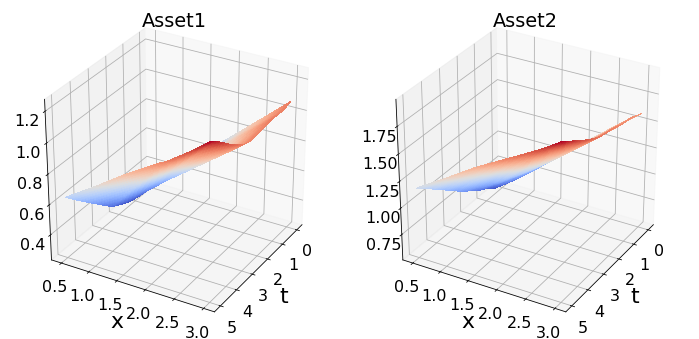

In [69]:
def PlotStrat(net, device):
    
    t = np.linspace(0, 5, 100)
    X_delta_t = np.linspace(0.5, 3, 100)
     
    x1, x2 = np.meshgrid(t, X_delta_t)
    
    x = np.zeros((x1.shape[0], x1.shape[1], 2))
    
    x[:,:,0] = x1
    x[:,:,1] = x2
    
    x_t = torch.tensor(x, dtype=torch.float, device=device )
    
    w_t = net(x_t).cpu().detach().numpy()
        
    fig = plt.figure(figsize=(10,5))
    
    for i in range(w_t.shape[2]):
            
        ax = fig.add_subplot(1, w_t.shape[2], i+1, projection='3d')
        
        ax.plot_surface(x1, x2, w_t[:,:,i], cmap=cm.coolwarm, linewidth=0, antialiased=False)
        
        ax.view_init(30, 30)
        
        plt.title('Asset' + str(i+1))
        
        plt.xlabel('t')
        plt.ylabel('x')
    
    plt.tight_layout()
    plt.show()
    
    
    # for i in range(0,x1.shape[1],5):
    
    #     fig = plt.figure(figsize=(10,5))
    
    #     plt.subplot(1,2,1)
    #     plt.plot(X_delta_t, w_t[:,i,0])
        
    #     plt.subplot(1,2,2)
    #     plt.plot(X_delta_t, w_t[:,i,1])
        
    #     plt.suptitle("t={0:0.2f}".format(t[i]) , fontsize= 20 )
    #     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #     plt.show()
    
    
PlotStrat(net, device)
    

In [70]:
#%debug

In [71]:
import pickle 

In [72]:
pickle.dump( net, open( "net_Nov2.p", "wb" ) )